## PyTorch_RNN Template
* First, we'll create our data
* Then, define an RNN in PyTorch
* Finally, we'll train our network and see how it performs

In [6]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

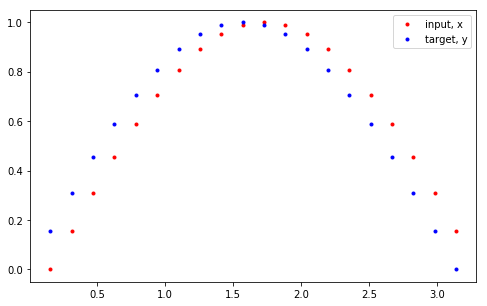

In [7]:
plt.figure(figsize=(8,5))
seq_length = 20

time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension

x = data[:-1] 
y = data[1:] # just remove one step
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y
plt.legend(loc='best')
plt.show()

* RNN parameters: input_size, hidden_size, n_layers, batch_first, dropout, bidirectional
* https://www.jianshu.com/p/41c15d301542

In [14]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        r_out, hidden = self.rnn(x, hidden)
        r_out = r_out.view(-1, self.hidden_size) # 输入全连接层后先打成一维
        output = self.fc(r_out)
        return output, hidden

    '''
    rnn = nn.RNN(10, 20, 2)
    input = torch.randn(5, 3, 10)
    h0 = torch.randn(2, 3, 20)
    output, hn = rnn(input, h0)
    '''

In [15]:
# test that dimensions are as expected
test_rnn = RNN(input_size = 1, output_size = 1, hidden_size = 10, n_layers = 2)
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1)) # resize改变数组的尺寸大小，使用reshape用来增加数组的维度
data

array([[0.00000000e+00],
       [1.64594590e-01],
       [3.24699469e-01],
       [4.75947393e-01],
       [6.14212713e-01],
       [7.35723911e-01],
       [8.37166478e-01],
       [9.15773327e-01],
       [9.69400266e-01],
       [9.96584493e-01],
       [9.96584493e-01],
       [9.69400266e-01],
       [9.15773327e-01],
       [8.37166478e-01],
       [7.35723911e-01],
       [6.14212713e-01],
       [4.75947393e-01],
       [3.24699469e-01],
       [1.64594590e-01],
       [1.22464680e-16]])

In [18]:
test_input = torch.Tensor(data).unsqueeze(0)
test_out, test_h = test_rnn(test_input, None)
print(test_input.size(), test_out.size(), test_h.size())

torch.Size([1, 20, 1])torch.Size([20, 1])torch.Size([2, 1, 10])


## Train RNN:

In [19]:
input_size=1 
output_size=1
hidden_size=32
n_layers=1
rnn = RNN(input_size, output_size, hidden_size, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


### Loss and Optimization:
* Tips: It's typical to use an Adam optimizer for recurrent models

In [20]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

In [21]:
def train(rnn, n_steps, print_every):
    hidden = None    # Must initialize the hidden state
    for batch_i, step in enumerate(range(n_steps)):
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1
        x = data[:-1]
        y = data[1:]
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        prediction, hidden = rnn(x_tensor, hidden)
        hidden = hidden.data
        loss = criterion(prediction, y_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # show
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())    
            # 如果tensor只有一个元素那么调用item方法的时候就是将tensor转换成python的scalar，否则报错
            plt.plot(time_steps[1:], x, 'r.')                                 # input
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    return rnn

Loss:0.3610018789768219


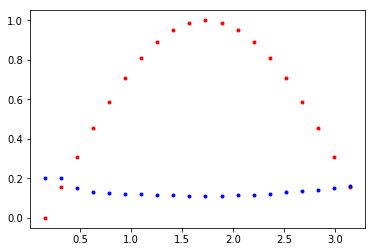

Loss:0.05101749300956726


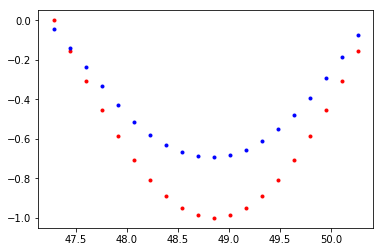

Loss:0.0069917128421366215


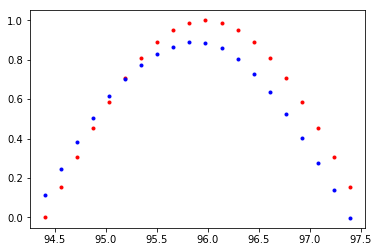

Loss:0.00029740159516222775


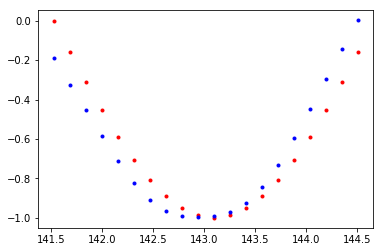

Loss:0.00048039661487564445


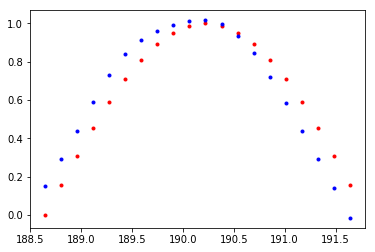

In [22]:
trained_rnn = train(rnn, n_steps = 75, print_every = 15)